<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Style Transfer

## Objectives
- To explore an alternative use of DNNs by implementing the style transfer algorithm ([Gatys et. al. 2016](https://arxiv.org/pdf/1508.06576.pdf)).
- To understand the importance of a complex loss function.
- To see how we can optimize not only over network parameters, but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function,
we will give you the code for this.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [ ]:
# Use this code to upload your own images

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving spence.jpeg to spence (1).jpeg

Upload Style Image


Saving starry.jpeg to starry.jpeg
Content Path: <_io.BytesIO object at 0x7a2c44aa6bb0>
Style Path: <_io.BytesIO object at 0x7a2c3c9e7ab0>


In [ ]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
content_image = nn.Parameter(content_image)

style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()
content_image = nn.Parameter(content_image)

In [ ]:
# Display the images
toPIL = transforms.ToPILImage()

def display(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)


___

### Part 1
Create a network instance to extract the layers needed for statistics

**TODO:**

* Correctly initialize a VGGIntermediate object to extract style and content
* Gather content statistics from the outputs of intermediate layers for the content image
* Gather style statistics for the style image

**DONE:**



In [ ]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place.
          m.inplace = False          # the model has a hard time going backwards on the in place functions.

        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))

  def forward(self, x):
    self.vgg(self.norm(x))
    return self.intermediates

In [ ]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

# Choose the layers to use for style and content transfer
contentLayers = [19]
styleLayers = [0, 5, 10, 17, 24] #24

contentInter = {}
styleInter = {}

# Create the vgg network in eval mode
#  with our forward method that returns the outputs of the intermediate layers we requested
def scope():
  try:
    gc.collect()
    print(torch.cuda.memory_allocated() / 1e9)

    contentModel = VGGIntermediate(contentLayers)
    contentModel.cuda()
    styleModel = VGGIntermediate(styleLayers)
    styleModel.cuda()


    contentData = contentModel(content_image)
    styleData = styleModel(style_image)



    for i in contentLayers:
      contentInter[vgg_names[i]] = contentData[i]

    for i in styleLayers:
      styleInter[vgg_names[i]] = styleData[i]



  except:
    __ITB__()

scope()

# Cache the outputs of the content and style layers for their respective images

0.453484032


<ipython-input-17-3d6c234280c9>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-17-3d6c234280c9>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


___

### Part 2
Create modules for the style and content loss

Note: You may want to try part 4 before implementing the losses to ensure you understand how style transfer loss works.

**TODO:**

* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the object
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the object

**DONE:**


In [ ]:
def gram_matrix(input):
  b,c,h,w = input.size()
  input = input.view(b*c, -1)
  return torch.mm(input, input.t())

class ContentLoss(nn.Module):
  def __init__(self, og_input, gen_input):
      super(ContentLoss, self).__init__()
      self.og_input = og_input
      self.gen_input = gen_input

  def forward(self):
    sumLoss = nn.MSELoss(reduction='sum')

    for layer in self.og_input:
      layerLoss = sumLoss(self.gen_input[layer], self.og_input[layer].detach())/2
      return layerLoss


class StyleLoss(nn.Module):
  def __init__(self, og_input, gen_input):
      super(StyleLoss, self).__init__()
      self.og_input = og_input
      self.gen_input = gen_input


  def forward(self):
    totalLoss = 0
    loss = nn.MSELoss()

    for layer in self.og_input:
      style_gram = gram_matrix(self.og_input[layer].detach());
      ip_gram = gram_matrix(self.gen_input[layer]);
      layerLoss = loss(ip_gram, style_gram)
      totalLoss += layerLoss

    return totalLoss

# Instantiate a content loss module for each content layer
#  with the content reference image outputs for that layer for comparison

# Instantiate a style loss module for each style layer
#  with the style reference image outputs for that layer for comparison


___

### Part 3
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

* Use an Adam optimizer (try learning rate of .1, but feel free to experiment)
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!
* Experiment with different hyperparameters or network layers until you're satisfied with your final image

**DONE:**



<ipython-input-17-3d6c234280c9>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-17-3d6c234280c9>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


0.510013952


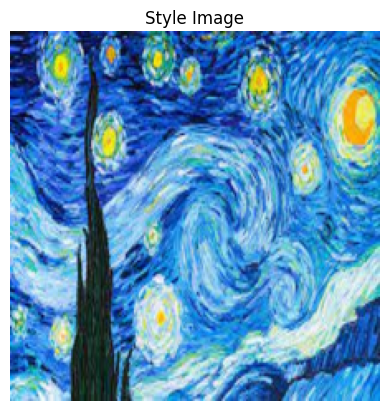

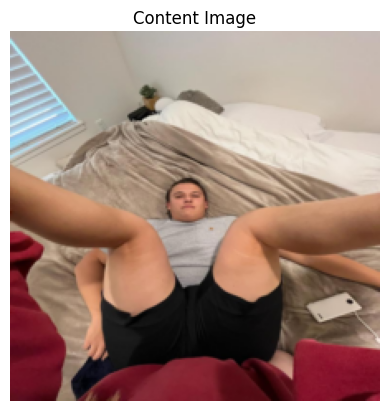

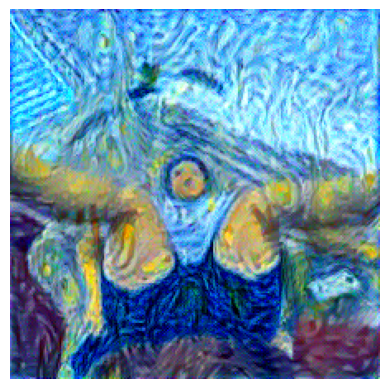

In [ ]:
# Start with a copy of the content image

plt.figure()
plt.axis('off')
display(style_image, title='Style Image')
plt.figure()
plt.axis('off')
display(content_image, title='Content Image')


styleWeight = 10000000
generated_image = torch.clone(content_image).detach()
generated_image = nn.Parameter(generated_image, requires_grad=True)
optimizer = optim.Adam([generated_image], lr=0.05)

generatedModel = VGGIntermediate(styleLayers + contentLayers)
generatedModel.cuda()


styleLossesArray = []
contentLossesArray = []
totalLossesArray = []

def scope():
  try:
    gc.collect()
    print(torch.cuda.memory_allocated() / 1e9)

    # for epochs:
    # Call your model, figure out loss and accuracy
    num_epochs = 100
    loop = tqdm(total=num_epochs, position=0, leave=False)
    for epoch in range(num_epochs):

        optimizer.zero_grad()
        generatedData = generatedModel(generated_image)

        generatedInter = {}
        for i in styleLayers + contentLayers:
              generatedInter[vgg_names[i]] = generatedData[i]

        style_loss = StyleLoss(styleInter, generatedInter)
        content_loss = ContentLoss(contentInter, generatedInter)
        c_l = content_loss()
        s_l = style_loss()
        totalLosses = c_l + (styleWeight*s_l)

        contentLossesArray.append(c_l.item())
        styleLossesArray.append(s_l.item())
        totalLossesArray.append(totalLosses.item())

        totalLosses.backward(retain_graph=True)

        loop.set_description('epoch:{} loss:{:.4f}'.format(epoch, totalLosses.item()))
        loop.update(1)

        optimizer.step()

    loop.close()


  except:
    __ITB__()

scope()


# Run the optimizer on the images to change the image
#  using the loss of the style and content layers
#  to backpropagate errors

# Show the image

generated_image = torch.clamp(generated_image, min=0, max=1)

plt.figure()
plt.axis('off')
display(generated_image)

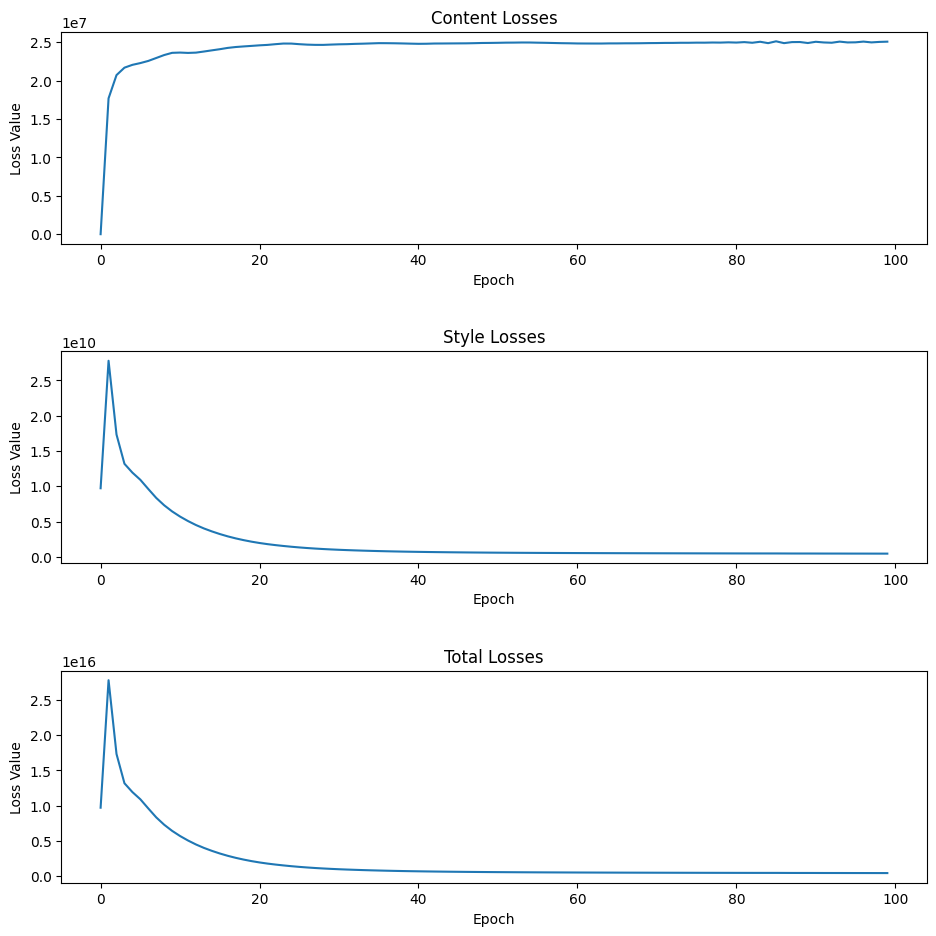

In [ ]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(311)
ax.plot(range(len(contentLossesArray)), contentLossesArray)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss Value")
ax.set_title("Content Losses")

ax = fig.add_subplot(312)
ax.plot(range(len(styleLossesArray)), styleLossesArray)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss Value")
ax.set_title("Style Losses")

ax = fig.add_subplot(313)
ax.plot(range(len(totalLossesArray)), totalLossesArray)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss Value")
ax.set_title("Total Losses")

fig.tight_layout(pad=3.0)
plt.show()

### Part 4

Show that you understand style transfer by describing the key equations of (Gatys 2016) in your own words.

**TODO:**

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

Equation 1:
  $\mathcal{L}_{content} (\vec{p},\vec{x},l) = \frac{1}{2} \sum_{i,j} (F_{ij}^l-P_{ij}^l)^2$

  $ Attachment = \frac{Covered_{all} - Covered_{all}}{Eligible} \sum_{i,j} (F_{ij}^l-P_{ij}^l)^2$ +
  \frac

  Equation 1 is the content loss function which takes in 3 inputs: The original Image ($\vec{p}$), the generated image ($\vec{x}$), and the layer of the vgg model that both were run through. The loss is then calculated from the output of the vgg model of both images (original and generated) at this layer by summing the squared results of $F_{ij}^l-P_{ij}^l$ where $F_{ij}^l$ is the activation of the ith filter at position j. At each filter level this means the equations will subtract a matrix of size M from the generated image layer from the matrix of the same size and same filter from the original image layer, square it, and sum it with the same calculation of all of the other filter layers. This ultimately works out to just be a Summed Squared Error of the particular layer between the generated image and the original image. Which since we are using a copy of the content image as our generated image, will be relatively close to 0.
***

- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

Equation 3:
$G_{ij}^l = \sum_k F_{ik}^l F_{jk}^l$

Equation 3 is used to remove the global features from our style specific feature map and does so by computing a Gram matrix ($G_{ij}^l$), which is simply the inner product between the feature maps of two different filters ($ i, j$) from the same convolution  layer ($F^l$).


***
- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

Equation 4:
$E_l = \frac{1}{4 N_l^2 M_l^2} \sum_{i,j} (G_{ij}^l - A_{ij}^l)^2$

Equation 4 is the start of the style loss calculation which is taking a Means Squared Error calculation between the gram matrices of the outputs of both the style layers of the original image and the style layers of the generated image (respectively represented by $A_{ij}^l$ and $G_{ij}^l$) This means squared error is generated across all of the different filters of that given layer represented by ($ i, j$) and uses as well the values of $N_l$ which is the total number of filers in this layer, and $M_l$ which is the height x width matrix size in each filter of this layer.

***
- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

Equation 5:
$\mathcal{L}_{style} (\vec{a}, \vec{x}) = \sum_{l=0}^L w_l E_l$

Equation 5 is the cumulative style loss function which uses the result from equation 4. It takes in as inputs The original Image ($\vec{a}$), the generated image ($\vec{x}$). It sums all of the style loss values (equation 4: $E_l$) from each selected layer of the vgg model ($l$) that both the input and the generated images were run against. It also has the ability here to apply weights to each of these layers. These weights are mostly arbitrary and could just be left at a default of one each, but if certain emphasis is desired on the higher/lower network style traits, that could be applied there.